In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils import *

from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('../raw_data/skyscanner_data_171223')

In [3]:
data.columns

Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin', 'dayofweek',
       'Seg_0_OperatingCarrierIATA', 'Seg_1_OperatingCarrierIATA',
       'Seg_2_OperatingCarrierIATA', 'Seg_3_OperatingCarrierIATA',
       'Total_Flight_Distance', 'Total_Flight_Duration', 'passengers',
       'PricePerPax', 'ItineraryRedirects', 'ODRedirects'],
      dtype='object')

In [4]:
no_nan = data.dropna(subset=['OriginApt', 'DestinationApt', 'DurationMin', 'PricePerPax', 'DestinationCtry'])

In [5]:
columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']


In [6]:
economy_flights = no_nan[(no_nan['PricePerPax'] > 0) & (no_nan['PricePerPax'] < 2000)]

In [7]:
distance_makes_sense_flights = economy_flights[(economy_flights["TravelDistanceKm"]<= economy_flights["Total_Flight_Distance"]) &
                                               (economy_flights["Total_Flight_Distance"] <= 5*economy_flights["TravelDistanceKm"])]

In [8]:
processed_data, scalers = all_preprocessing(distance_makes_sense_flights,columns, scale_itin_redirects, 'Score_Z_score_0_50', box_cox, yeo_johnson,
                                   target_func_param1='ItineraryRedirects', target_func_param2=0, target_func_param3=50)

/Users/antonis/code/LaGenace/OptiFlyAi/Notebooks/../utils.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[column] = raw_data[column].astype('float64')
/Users/antonis/code/LaGenace/OptiFlyAi/Notebooks/../utils.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data[column] = raw_data[column].astype('float64')
/Users/antonis/code/LaGenace/OptiFlyAi/Notebooks/../utils.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

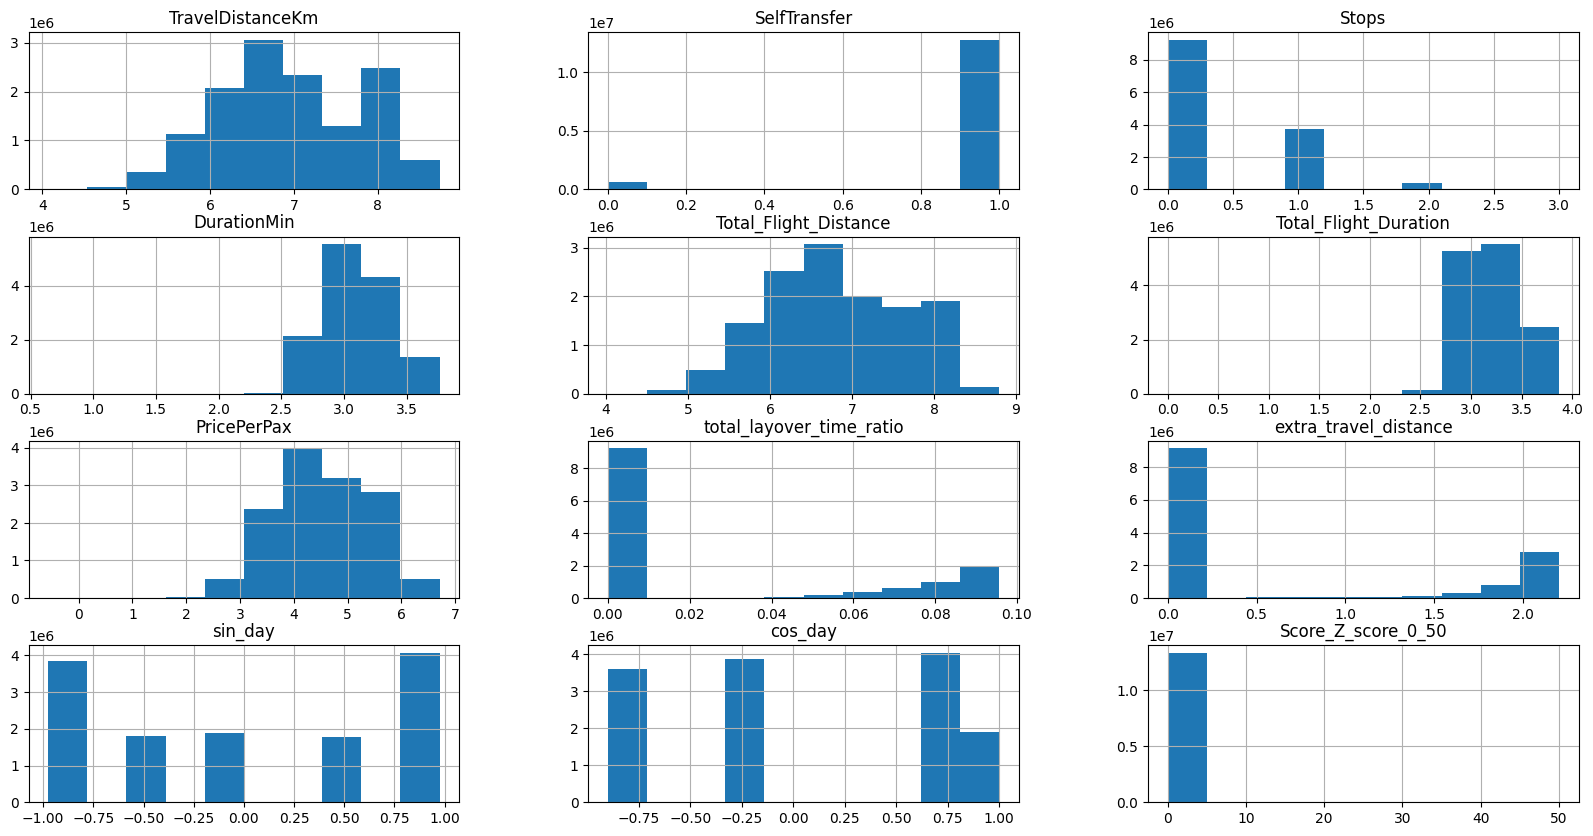

In [9]:
processed_data.hist(figsize=(20, 10));

In [10]:
clean_processed_data = processed_data.dropna(subset=['Score_Z_score_0_50'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(clean_processed_data.drop('Score_Z_score_0_50', axis=1),
                                                    clean_processed_data['Score_Z_score_0_50'], test_size=0.2, random_state=42)

In [12]:
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import category_encoders as ce
from scipy import stats
from typing import List, Callable, ClassVar

def process_new_data2(original_data:pd.DataFrame, new_data:pd.DataFrame, scalers, colums_to_keep:List[str],
                     box_cox_columns:List[str]=False, yeo_johnson_columns:List[str]=False, log_transform_columns:List[str]=False, min_max_columns:List[str]=False,
                     od_encoding:bool=False, operator_encoding:bool=False):
    """
    This function processes new data, using scalers and encoders from the training set
    It only returns the columns stated in columns_to_keep, and encoded columns if those options flipped to True

    original_data: This is used for encoding - can have dummy data if no encoding is taking place.

    new_data: The data you are processing

    scalers: Must be a Class variable of scalers from the all_preprocessing function

    columns_to_keep: this is the list of columns you want to keep, if daysofweek, it only returns the cosin columns and drops daysofweek

    _columns variables: List of columns you want in that scaling step

    od_encoding + operator_encoding: Boolean, only flip if you want to encode new data.
    """

    # DATA CLEANING

    # Filling the Null itinerary_fare data with booked_fare
    new_data['itinerary_fare'].fillna(new_data['booked_fare'], inplace=True)

    # Dropping data where itinerary_fare remains Null
    clean_data = new_data.dropna(subset=['itinerary_fare']).copy().reset_index()

    # FEATURE ENGINEERING
    clean_data['DurationMin'] = clean_data['flight_time'] + clean_data['connection_time']

    clean_data['total_layover_time'] = clean_data['DurationMin'] - clean_data['flight_time']
    clean_data['total_layover_time_ratio'] = clean_data['connection_time'] / clean_data['DurationMin']

    clean_data['extra_travel_distance'] = clean_data['total_distance'] - clean_data['direct_distance']
    clean_data['extra_travel_distance_ratio'] =  clean_data['total_distance'] / clean_data['direct_distance']

    if 'seg_0' not in clean_data.columns:
        clean_data['seg_0'] = 0
        clean_data['seg_1'] = 0

        for i in range(len(clean_data)):
            listtt = clean_data['flights'][i].split(',')
            clean_data['seg_0'][i] = listtt[0][:2]
            clean_data['seg_1'][i] = listtt[1].strip()[:2]

    # Renaming the columns
    col_rename_dict = {'origin': 'OriginApt', 'destination':'DestinationApt', 'days_to_travel':'TravelHorizonDays', 'total_distance':'Total_Flight_Distance',
                    'direct_distance':'TravelDistanceKm', 'connection_time':'total_layover_time', 'flight_time':'Total_Flight_Duration','itinerary_fare':'PricePerPax',
                    'seg_0':'Seg_0_OperatingCarrierIATA', 'seg_1':'Seg_1_OperatingCarrierIATA', 'seg_2':'Seg_2_OperatingCarrierIATA', 'seg_3':'Seg_3_OperatingCarrierIATA'}

    clean_data = clean_data.rename(columns=col_rename_dict).copy()

    #TEMP creating Stops and SelfTransfer data
    clean_data['Stops'] = 1
    clean_data['SelfTransfer'] = True

    #DATA CLEANING
    for column in clean_data.select_dtypes(include=['int64']).columns:
        clean_data[column] = clean_data[column].astype('float64')

    # ENCODING
    if od_encoding:
        #Binary encoding origin
        origin_encoded = encoding_new_data(original_data=original_data, data_to_be_processed=clean_data, column='OriginApt', encoder=scalers.o_encoder)

        # Binary encoding Destination
        destination_encoded = encoding_new_data(original_data, clean_data, 'DestinationApt', scalers.d_encoder)

        # Updating the dataset with the encoded columns
        clean_data = pd.concat([clean_data, origin_encoded, destination_encoded], axis=1)

        # Ensuring the columns are returned at the end of the function
        colums_to_keep.extend(origin_encoded.columns.to_list())
        colums_to_keep.extend(destination_encoded.columns.to_list())

    if operator_encoding:
        seg_0_op_iata = encoding_new_data(original_data, clean_data, 'Seg_0_OperatingCarrierIATA', scalers.seg_0_encoder)
        seg_1_op_iata = encoding_new_data(original_data, clean_data, 'Seg_1_OperatingCarrierIATA', scalers.seg_1_encoder)

        if 'Seg_2_OperatingCarrierIATA' in clean_data.columns:
            seg_2_op_iata = encoding_new_data(original_data, clean_data, 'Seg_2_OperatingCarrierIATA', scalers.seg_2_encoder)
        else:
            seg_2_op_iata = False

        if 'Seg_3_OperatingCarrierIATA' in clean_data.columns:
            seg_3_op_iata = encoding_new_data(original_data, clean_data, 'Seg_3_OperatingCarrierIATA', scalers.seg_3_encoder)
        else:
            seg_3_op_iata = False

        # Updating the dataset with the encoded columns

        dfs_to_concat = [clean_data, seg_0_op_iata, seg_1_op_iata]

        if seg_2_op_iata:
            dfs_to_concat.append(seg_2_op_iata)
        if seg_3_op_iata:
            dfs_to_concat.append(seg_3_op_iata)

        clean_data = pd.concat(dfs_to_concat, axis=1)

        # Ensuring the columns are returned at the end of the function
        if operator_encoding:
            colums_to_keep.extend(seg_0_op_iata.columns.to_list())
            colums_to_keep.extend(seg_1_op_iata.columns.to_list())
            if seg_2_op_iata:
                colums_to_keep.extend(seg_2_op_iata.columns.to_list())
            if seg_3_op_iata:
                colums_to_keep.extend(seg_3_op_iata.columns.to_list())

    colums_to_keep.append('bookings')

    # SCALING
    # Box cox
    if box_cox_columns:
        for col in box_cox_columns:
            clean_data.loc[:,col]  = stats.boxcox(clean_data[col], lmbda=scalers.box_lambda[col])

    # Yeo-johnson
    if yeo_johnson_columns:
        for col in yeo_johnson_columns:
            clean_data.loc[:,col] = stats.yeojohnson(clean_data[col], lmbda=scalers.yeo_lambda[col])

    # Log transformations
    if log_transform_columns:
        for col in log_transform_columns:
            clean_data.loc[:,col] = np.log1p(clean_data[col])

    #Min max scaling
    if min_max_columns:
        for col in min_max_columns:
            clean_data.loc[:,col] = scalers.minmax_scaler[col].transform(clean_data[[col]])

    if 'SelfTransfer' in colums_to_keep:
        #Inversing the importance of SelfTransfer, so Non Self Transfer is seen as better by the model
        clean_data['SelfTransfer'] = clean_data['SelfTransfer'].apply(convert_bool_to_num)

    data_to_return = clean_data[colums_to_keep].copy()

    if 'dayofweek' in colums_to_keep:
        # Cyclical encoding
        data_to_return['sin_day'] = np.sin(2 * np.pi * data_to_return['dayofweek'] / 7)
        data_to_return['cos_day'] = np.cos(2 * np.pi * data_to_return['dayofweek'] / 7)

        # Dropping day of week as it is no longer neccesary
        data_to_return = data_to_return.drop(columns=['dayofweek']).copy()

    return data_to_return

In [13]:
dohop_data = pd.read_csv('../raw_data/OptiFlyAI_testset.csv')
processed_dohop = process_new_data2(original_data=clean_processed_data, new_data=dohop_data, scalers=scalers,
                 colums_to_keep=columns, box_cox_columns=box_cox, yeo_johnson_columns=yeo_johnson)

/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_6037/1727809782.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['seg_0'][i] = listtt[0][:2]
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_6037/1727809782.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'U2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  clean_data['seg_0'][i] = listtt[0][:2]
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_6037/1727809782.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [14]:
dohop_data.columns

Index(['flights', 'origin', 'destination', 'cnx_airport', 'flight_time',
       'connection_time', 'dayofweek', 'bkgs_with_no_content', 'pax',
       'bookings', 'booked_fare', 'total_distance', 'direct_distance',
       'itinerary_fare'],
      dtype='object')

# Random forrest Model

In [29]:
forrest = RandomForestRegressor(n_estimators=10, criterion='poisson', max_depth=25)
forrest.fit(X_train, y_train)

RandomForestRegressor(criterion='poisson', max_depth=25, n_estimators=10)

In [30]:
processed_dohop.shape, dohop_data.shape

((595765, 12), (1018923, 14))

In [37]:
dohop_data['bookings'].isna().sum()

1011761

In [31]:
dohop_data.columns

Index(['flights', 'origin', 'destination', 'cnx_airport', 'flight_time',
       'connection_time', 'dayofweek', 'bkgs_with_no_content', 'pax',
       'bookings', 'booked_fare', 'total_distance', 'direct_distance',
       'itinerary_fare'],
      dtype='object')

In [32]:
def evaluate_model(data, model):
    data["predicted_score"] = model.predict(data.drop('bookings', axis=1)).flatten()

    # Create a new colummn bucketed into "booked" and "not-booked"
    data["status"] = np.where(data["bookings"] > 0, "booked", "not-booked")

    # Filter down the dataset to those rows which were booked
    booked_data = data[data["status"] == "booked"]

    # Filter down the dataset to those rows which were not booked
    not_booked_data = data[data["status"] == "not-booked"]

    # Compute minimum score threshold for booked and not-booked data
    min_booked_score = data.loc[data["status"] == "booked", "predicted_score"].min()
    min_not_booked_score = data.loc[data["status"] == "not-booked", "predicted_score"].min()

    # Check for the edge case and issue a warning, if it applies
    if min_booked_score < min_not_booked_score:
        return "Edge case encountered: Min score of booked rows is lower than min score of not-booked rows."

    metrics = {"min_threshold": min_booked_score,
               "total_rows": data.shape[0],
               "TP": booked_data[data["predicted_score"] >= min_booked_score].shape[0],
               "FP": not_booked_data[data["predicted_score"] >= min_booked_score].shape[0],
               "TN": not_booked_data[data["predicted_score"] < min_booked_score].shape[0],
               "FN": booked_data[data["predicted_score"] < min_booked_score].shape[0],
               }

    return metrics

In [33]:
processed_dohop.isna().sum()

TravelDistanceKm               490
SelfTransfer                     0
Stops                            0
DurationMin                      0
Total_Flight_Distance          558
Total_Flight_Duration            0
PricePerPax                      0
total_layover_time_ratio         0
extra_travel_distance          558
bookings                    588603
sin_day                          0
cos_day                          0
dtype: int64

In [34]:
dohop_dropped_na = processed_dohop.dropna(subset=['TravelDistanceKm', 'Total_Flight_Distance'])

In [39]:
dohop_dropped_na['bookings'].isna().sum() - dohop_dropped_na.shape[0]

-7082

In [35]:
evaluate_model(dohop_dropped_na, forrest)

/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_6037/3781935284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["predicted_score"] = model.predict(data.drop('bookings', axis=1)).flatten()
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_6037/3781935284.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["status"] = np.where(data["bookings"] > 0, "booked", "not-booked")
/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_6037/3781935284.py:23: UserWarning: Boolean Se

{'min_threshold': 0.3559356535380518,
 'total_rows': 595207,
 'TP': 7082,
 'FP': 588118,
 'TN': 7,
 'FN': 0}

# Model results

### Results for Poisson Random Forrest with 10 trees, and 20 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']


- 'min_threshold': 0.3559356535380518,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588118,
- 'TN': 7,
- 'FN': 0

Training time - 10 minutes

### Results for Poisson Random Forrest with 10 trees, and 25 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- min_threshold': 0.3980702486833349,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587975,
- 'TN': 150,
- 'FN': 0

Training time - 11 minutes

### Results for Poisson Random Forrest with 15 trees, and 20 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.4278422656407467,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587982,
- 'TN': 143,
- 'FN': 0

Training time - 17 minutes

### Results for Poisson Random Forrest with 30 trees, and 20 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.40947495385794425,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 588111,
- 'TN': 14,
- 'FN': 0

Training time - 107 minutes

### Results for Poisson Random Forrest with 5 trees, and 30 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.37001877943373246,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587691,
- 'TN': 434,
- 'FN': 0

Training time - 6 Minutes

### Results for Poisson Random Forrest with 7 trees, and 40 max depth. 

columns = ['TravelDistanceKm', 'SelfTransfer', 'Stops',
           'DurationMin', 'dayofweek', 'Total_Flight_Distance', 'Total_Flight_Duration', 'PricePerPax',
           'total_layover_time_ratio', 'extra_travel_distance']

box_cox = ['PricePerPax', 'TravelDistanceKm']

yeo_johnson = ['DurationMin', 'Total_Flight_Duration', 'Total_Flight_Distance', 'total_layover_time_ratio', 'extra_travel_distance']

- 'min_threshold': 0.3839483185231023,
- 'total_rows': 595207,
- 'TP': 7082,
- 'FP': 587455,
- 'TN': 670,
- 'FN': 0

Training time - 9 minutes